# Adding a Web Search Module


- Author: [Sun Hyoung Lee](https://github.com/LEE1026icarus)
- Design: [LeeYuChul](https://github.com/LeeYuChul)
- Peer Review :
- Proofread:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/08-Embeeding/04-UpstageEmbeddings.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/08-Embeeding/04-UpstageEmbeddings.ipynb)

## Overview

**Steps**

1. Perform Naive RAG (Retrieve-and-Generate)  
2. Conduct a Groundedness Check on Retrieved Documents  
3. (This Tutorial) Add Web Search  

**Notes**

- This builds on content from the previous tutorial, so there may be overlapping sections. For any unclear explanations, please refer to the earlier tutorial.  

![langgraph-web-search](assets/04-langgraph-add-web-search-langgraph-web-search.png)

### Table of Contents

- [Overview](#overview)
- [Environement Setup](#environment-setup)
- [Creating a Basic PDF-Based Retrieval Chain](#creating-a-basic-pdf-based-retrieval-chain)
- [State Definition](#state-definition)
- [Node Definition](#node-definition)
- [Adding Search Node](#adding-search-node)
- [Edges](#edges)
- [Graph Execution](#graph-execution)

### References

- [LangGraph Tutorials](https://langchain-ai.github.io/langgraph/tutorials/)
---


## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

 **[Note]** 
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [ `langchain-opentutorial` ](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.


In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain_community",
        "langgraph",
        "typing",
        "langchain_openai",
        "langchain_core"
        "langchain_opentutorial"
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [3]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "OPENAI_API_KEY": "",
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "true",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
            "LANGCHAIN_PROJECT": "CH04-LangGraph-Add-Web-Search",
            "TAVILY_API_KEY": ""
        }
    )

## Creating a Basic PDF-Based Retrieval Chain

Here, we create a Retrieval Chain based on a PDF document. This represents the simplest structure of a Retrieval Chain.

In LangGraph, the **Retriever** and **Chain** are created separately. This allows for detailed processing at each node.

**Note**

- Since this content builds on the previous tutorial, detailed explanations are omitted.

In [4]:
from rag.pdf import PDFRetrievalChain

# Load the PDF document
pdf = PDFRetrievalChain(
    ["data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf"]
).create_chain()

# Create retriever
pdf_retriever = pdf.retriever

# Create chain
pdf_chain = pdf.chain

## State Definition
`State` : Defines the shared state between nodes in a Graph. 

Typically uses the `TypedDict` format.

This time, we're adding relevance check results to the State.


In [5]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

# Definition of GraphState
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # The question
    context: Annotated[str, "Context"]  # Search results from the document
    answer: Annotated[str, "Answer"]  # The answer
    messages: Annotated[list, add_messages]  # Messages (accumulated as a list)
    relevance: Annotated[str, "Relevance"]  # Relevance


## Node Definition

- `Nodes` : These are nodes that process each step. They are typically implemented as Python functions. Both input and output are State values.

**Note**

- Receives a `State` as input, performs the defined logic, and returns an updated `State`.

In [6]:
from langchain_openai import ChatOpenAI
from rag.evaluator import GroundednessChecker
from rag.messages import messages_to_history
from rag.utils import format_docs


# Document Retrieval Node
def retrieve_document(state: GraphState) -> GraphState:
    # Retrieve the latest question from the state.
    latest_question = state["question"]

    # Search the document to find relevant sections.
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # Format the retrieved documents (to use as input for the prompt).
    retrieved_docs = format_docs(retrieved_docs)

    # Save the retrieved documents in the "context" key.
    return GraphState(context=retrieved_docs)


# Answer Generation Node
def llm_answer(state: GraphState) -> GraphState:
    # Retrieve the latest question from the state.
    latest_question = state["question"]

    # Retrieve the context (search results) from the state.
    context = state["context"]

    # Call the chain to generate an answer.
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # Save the generated answer and the (user question, answer) messages in the state.
    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )


# Relevance Checking Node
def relevance_check(state: GraphState) -> GraphState:
    # Create a relevance evaluator.
    question_answer_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"
    ).create()

    # Perform relevance check ("yes" or "no").
    response = question_answer_relevant.invoke(
        {"question": state["question"], "context": state["context"]}
    )

    print("==== [RELEVANCE CHECK] ====")
    print(response.score)

    # Note: The relevance evaluator here can be customized with specific prompts.
    # Feel free to create your own Groundedness Check!
    return GraphState(relevance=response.score)


# Function (Router) for Relevance Check
def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"


## Adding Search Node

This time, we'll perform a Web Search using the `TavilySearch` tool.

Below is an example using the `TavilySearch` tool.

In [7]:
from rag.tavily import TavilySearch

# Create the search tool
tavily_tool = TavilySearch()

search_query =  "Where has the application of AI in healthcare been confined to so far?"

# Example of search using various parameters
search_result = tavily_tool.search(
    query=search_query,  # Search query
    max_results=3,  # Maximum number of search results
    format_output=True,  # Format the output
)

# Print the search results
print(search_result)


["<document><title>Artificial Intelligence and Healthcare: A Journey through ... - MDPI</title><url>https://www.mdpi.com/2075-1729/14/5/557</url><content>Artificial intelligence (AI) has emerged as a powerful tool in healthcare significantly impacting practices from diagnostics to treatment delivery and patient management. This article examines the progress of AI in healthcare, starting from the field's inception in the 1960s to present-day innovative applications in areas such as precision medicine, robotic surgery, and drug development.</content></document>", "<document><title>Artificial Intelligence and Healthcare: A Journey through History ...</title><url>https://pmc.ncbi.nlm.nih.gov/articles/PMC11122160/</url><content>Artificial intelligence (AI) has emerged as a powerful tool in healthcare significantly impacting practices from diagnostics to treatment delivery and patient management. This article examines the progress of AI in healthcare, starting from the field's inception in t

Package it as a search node and add it (create a function).

In [8]:
# Web Search Node
def web_search(state: GraphState) -> GraphState:
    # Create the search tool
    tavily_tool = TavilySearch()

    search_query = state["question"]

    # Example of search using various parameters
    search_result = tavily_tool.search(
        query=search_query,  # Search query
        topic="general",  # General topic
        max_results=6,  # Maximum number of search results
        format_output=True,  # Format the output
    )

    return {"context": search_result}


## Edges

- `Edges` : Python functions that determine the next `Node` to execute based on the current `State` .

There are various types such as regular edges and conditional edges.

In [9]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Define the graph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)

# Add the Web Search node
workflow.add_node("web_search", web_search)

# Add edges
workflow.add_edge("retrieve", "relevance_check")  # Retrieval -> Relevance Check

# Add conditional edges
workflow.add_conditional_edges(
    "relevance_check",  # Pass the result from the relevance check node to the is_relevant function.
    is_relevant,
    {
        "relevant": "llm_answer",  # If relevant, generate an answer.
        "not relevant": "web_search",  # If not relevant, perform a web search.
    },
)

workflow.add_edge("web_search", "llm_answer")  # Web Search -> Answer
workflow.add_edge("llm_answer", END)  # Answer -> End

# Set the entry point of the graph
workflow.set_entry_point("retrieve")

# Set the checkpointer
memory = MemorySaver()

# Compile the graph
app = workflow.compile(checkpointer=memory)

Visualize the compiled graph.

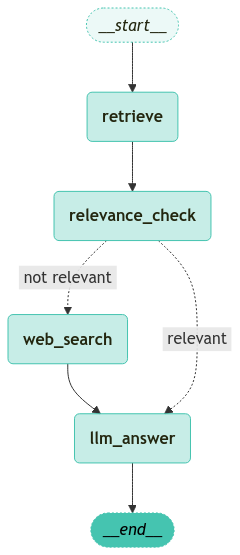

In [10]:
from rag.graphs import visualize_graph

visualize_graph(app)

## Graph Execution

- The `config` parameter passes configuration information needed for graph execution.
- `recursion_limit` : Sets the maximum number of recursions during graph execution.
- `inputs` : Passes the input information needed for graph execution.

If the `relevance_check` of the search results fails, it performs a search and provides web search results.

In [14]:
from langchain_core.runnables import RunnableConfig
from rag.messages import stream_graph, invoke_graph, random_uuid


# Config settings (maximum recursion limit, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# Input question
inputs = GraphState(question="Where has the application of AI in healthcare been confined to so far?")

# Execute the graph
invoke_graph(app, inputs, config, ["relevance_check", "llm_answer"])


==== [RELEVANCE CHECK] ====
yes

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
('user', 'Where has the application of AI in healthcare been confined to so far?')
('assistant', 'The application of AI in healthcare has so far been confined primarily to administrative tasks, such as Natural Language Processing for extracting information from clinical notes and predictive scheduling. \n\n**Source**\n- data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf (page 15)')


In [15]:
# Graph Streaming Output
stream_graph(app, inputs, config, ["relevance_check", "llm_answer"])



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [RELEVANCE CHECK] ====
yes

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
The application of AI in healthcare has so far been confined primarily to administrative tasks, such as Natural Language Processing for extracting information from clinical notes and predictive scheduling.

**Source**
- data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf (page 15)

In [16]:
# Final Output Check
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')


Question: Where has the application of AI in healthcare been confined to so far?
Answer:
The application of AI in healthcare has so far been confined primarily to administrative tasks, such as Natural Language Processing for extracting information from clinical notes and predictive scheduling.

**Source**
- data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf (page 15)
